# Notebook 2: Testing Various Models

In this notebook we test various models in two different ways:

1. Using the original train/valid/test split 
2. Using stratified cross-validation on all of the data

In the original paper the train and validation sets were balanced with respect to the class labels however the testing data is very imbalanced. The dataset on the whole is very imbalanced w.r.t. classes.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 5

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.utils.extmath import softmax
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
def get_data():
    try:
        #
        original = pd.read_feather('../data/original.feather')
    except:
        # Get Original Data
        original = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header = None)

        # Fix columns
        original.columns = ['Elevation', 'Aspect', 'Slope',
               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
               'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
               'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
               'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
               'Cover_Type']

        for col, dtype in original.dtypes.iteritems():
            if dtype.name.startswith('int'):
                original[col] = pd.to_numeric(original[col], downcast ='integer')
            elif dtype.name.startswith('float'):
                original[col] = pd.to_numeric(original[col], downcast ='float')
        
        if not os.path.isdir('../data'):
            os.mkdir('../data')
        original.to_feather('../data/original.feather')
    return original

In [4]:
%%time
original = get_data()

# Get feature columns
features = [x for x in original.columns if x not in ['Id','Cover_Type']]
wilderness_cols = [x for x in features if x.startswith('Wild')]
soil_cols = [x for x in features if x.startswith('Soil')]
binary_cols = [x for x in features if x.startswith('Soil') or x in wilderness_cols]
numerical_cols = [x for x in features if x not in binary_cols]

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for summary scores
new_rows = list()
old_rows = list()

Wall time: 48 ms


# Scoring Functions

In [5]:
# Scoring/Training Baseline Function
def train_cv(sklearn_model):
    
    print(f'{NUM_FOLDS}-fold Cross-Validation\n')
    
    # Store the holdout predictions
    oof_preds = np.zeros((original.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(original, original['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = original[features].iloc[train_idx]
        X_valid = original[features].iloc[valid_idx]
        y_train = original['Cover_Type'].iloc[train_idx]
        y_valid = original['Cover_Type'].iloc[valid_idx]

        
        # Create model
        start = time.time()
        model = clone(sklearn_model)
        model.fit(X_train, y_train)
        
        # validation predictions
        valid_preds = np.ravel(model.predict(X_valid))
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy:  {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    print("\nAverage Accuracy:", round(scores.mean(), 5))
    print("Worst Accuracy:", round(scores.min(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(original['Cover_Type'], oof_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    
    return scores.mean(), oof_preds

In [6]:
def train_original(sklearn_model):
    
    print('Original Train/Test Split')
    
    # Store the holdout predictions
    oof_preds = np.zeros((original.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Training and Validation Sets
    X_train = original[features].iloc[:15119]
    X_test = original[features].iloc[15119:]
    y_train = original['Cover_Type'].iloc[:15119]
    y_test = original['Cover_Type'].iloc[15119:]
        
    # Create model
    start = time.time()
    model = clone(sklearn_model)
    model.fit(X_train, y_train)
        
    # validation and test predictions
    test_preds = np.ravel(model.predict(X_test))
    accuracy = accuracy_score(y_test, test_preds)
    end = time.time()        
    time.sleep(0.5)
    
    print("\nAccuracy:", round(accuracy, 5))
    print(f'Training Time: {round(end-start, 2)}s\n')
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(y_test, test_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    
    return accuracy, test_preds

# Logistic Regression

In [7]:
# Logistic Regression
logit_pipeline = make_pipeline(
    RobustScaler(),
    LogisticRegression(
        solver = 'saga',
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

5-fold Cross-Validation


Fold 0 Accuracy:  0.72439 in 83.32s.
Fold 1 Accuracy:  0.72415 in 81.15s.
Fold 2 Accuracy:  0.72574 in 80.58s.
Fold 3 Accuracy:  0.72267 in 79.97s.
Fold 4 Accuracy:  0.72652 in 80.54s.

Average Accuracy: 0.72469
Worst Accuracy: 0.72267
Training Time: 405.56s



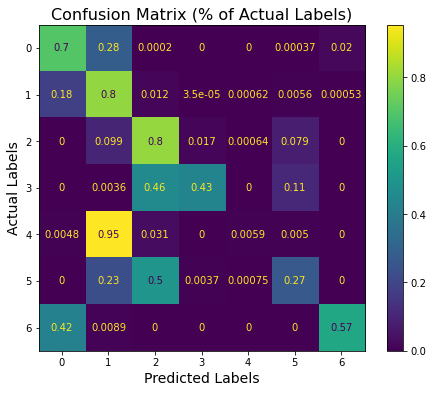

In [8]:
cv_score, oof_preds = train_cv(logit_pipeline)

new_rows.append((
    'Logistic_Regression', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))

Original Train/Test Split


Accuracy: 0.59386
Training Time: 2.51s



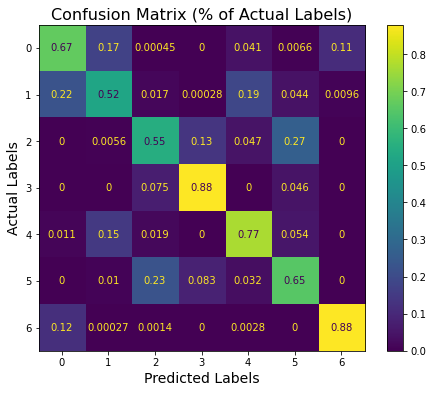

In [9]:
test_score, oof_preds = train_original(logit_pipeline)

old_rows.append((
    'Logistic_Regression', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Ridge Regression

In [10]:
# Class extending Ridge Regression
class ExtendedRidgeClassifier(RidgeClassifier):
    def predict_proba(self, X):
        return softmax(self.decision_function(X))
    
# Ridge Regression
ridge_pipeline = make_pipeline(
    RobustScaler(),
    ExtendedRidgeClassifier(
        solver = 'saga',
        random_state = RANDOM_SEED,
    ),
)

5-fold Cross-Validation


Fold 0 Accuracy:  0.701 in 207.93s.
Fold 1 Accuracy:  0.70206 in 222.9s.
Fold 2 Accuracy:  0.70189 in 229.77s.
Fold 3 Accuracy:  0.69861 in 223.62s.
Fold 4 Accuracy:  0.70192 in 226.05s.

Average Accuracy: 0.7011
Worst Accuracy: 0.69861
Training Time: 1110.28s



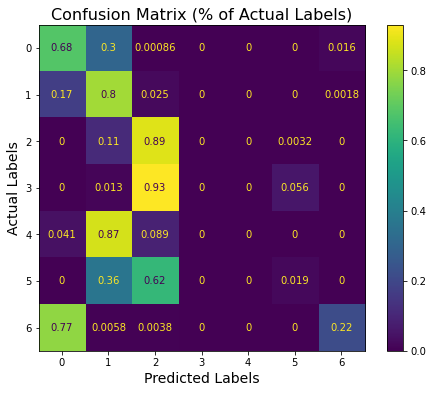

In [11]:
cv_score, oof_preds = train_cv(ridge_pipeline)

new_rows.append((
    'Ridge_Regression', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))

Original Train/Test Split


Accuracy: 0.54271
Training Time: 3.73s



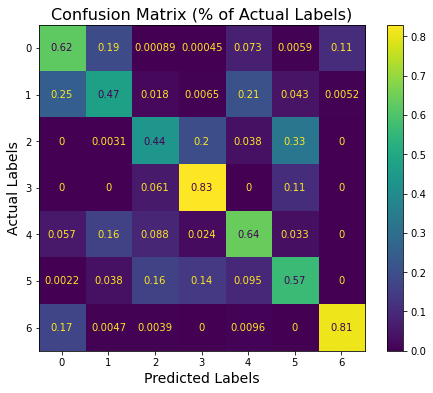

In [12]:
test_score, oof_preds = train_original(ridge_pipeline)

old_rows.append((
    'Ridge_Regression', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Linear Discriminant Analysis

In [13]:
# Linear Discriminant Analysis
lda_pipeline = make_pipeline(
    RobustScaler(),
    LinearDiscriminantAnalysis(),
)

5-fold Cross-Validation


Fold 0 Accuracy:  0.67946 in 3.57s.
Fold 1 Accuracy:  0.67941 in 3.59s.
Fold 2 Accuracy:  0.67995 in 3.53s.
Fold 3 Accuracy:  0.67655 in 3.55s.
Fold 4 Accuracy:  0.68301 in 3.55s.

Average Accuracy: 0.67967
Worst Accuracy: 0.67655
Training Time: 17.79s



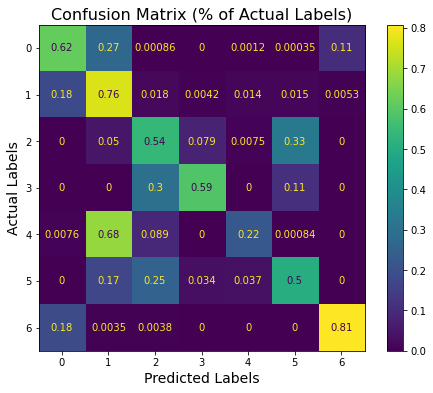

In [14]:
cv_score, oof_preds = train_cv(lda_pipeline)

new_rows.append((
    'LDA', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))

Original Train/Test Split


Accuracy: 0.58126
Training Time: 0.37s



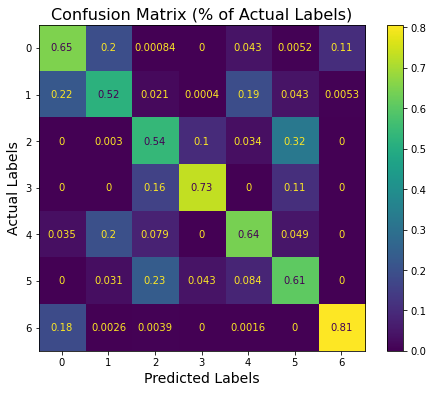

In [15]:
test_score, oof_preds = train_original(lda_pipeline)

old_rows.append((
    'LDA', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# SGDClassifier

In [16]:
# Extended SGDClassifier
class ExtendedSGDClassifier(SGDClassifier):
    def predict_proba(self, X):
        return softmax(self.decision_function(X))

# SGDClassifier
sgd_pipeline = make_pipeline(
    RobustScaler(), 
    ExtendedSGDClassifier(
        learning_rate = 'optimal', 
        penalty = 'l2', 
        random_state = RANDOM_SEED
    )
)

5-fold Cross-Validation


Fold 0 Accuracy:  0.71334 in 6.02s.
Fold 1 Accuracy:  0.71397 in 5.84s.
Fold 2 Accuracy:  0.71368 in 5.95s.
Fold 3 Accuracy:  0.71119 in 5.99s.
Fold 4 Accuracy:  0.71232 in 6.04s.

Average Accuracy: 0.7129
Worst Accuracy: 0.71119
Training Time: 29.84s



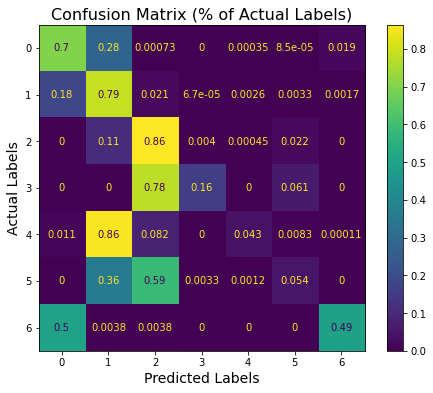

In [17]:
cv_score, oof_preds = train_cv(sgd_pipeline)

new_rows.append((
    'SGDClassifier', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))

Original Train/Test Split


Accuracy: 0.51881
Training Time: 0.71s



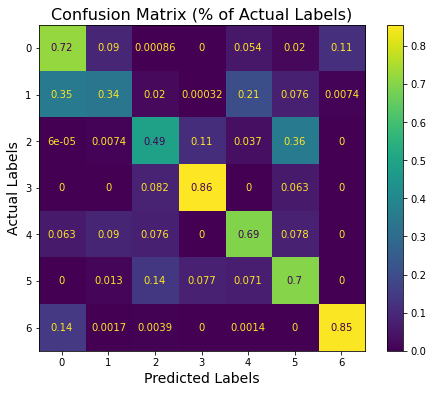

In [18]:
test_score, oof_preds = train_original(sgd_pipeline)

old_rows.append((
    'SGDClassifier', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Naive Bayes

In [19]:
# Naive Bayes Classifier
nb_pipeline = make_pipeline(
    RobustScaler(),
    MinMaxScaler(),
    MultinomialNB(),
)

5-fold Cross-Validation


Fold 0 Accuracy:  0.64276 in 0.92s.
Fold 1 Accuracy:  0.64205 in 0.94s.
Fold 2 Accuracy:  0.64276 in 0.93s.
Fold 3 Accuracy:  0.64037 in 0.9s.
Fold 4 Accuracy:  0.64216 in 0.95s.

Average Accuracy: 0.64202
Worst Accuracy: 0.64037
Training Time: 4.64s



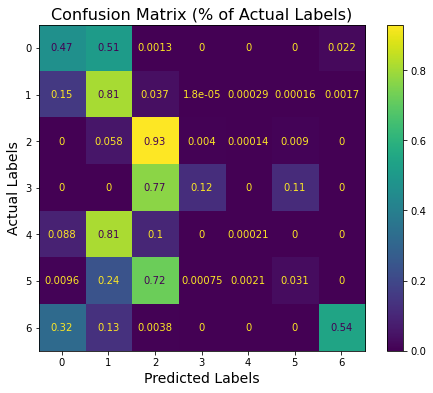

In [20]:
cv_score, oof_preds = train_cv(nb_pipeline)

new_rows.append((
    'Naive_Bayes', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))

Original Train/Test Split


Accuracy: 0.50226
Training Time: 0.51s



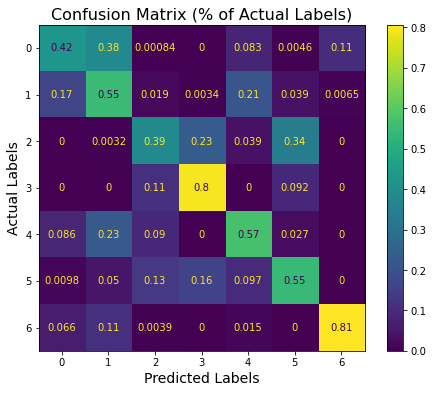

In [21]:
test_score, oof_preds = train_original(nb_pipeline)

old_rows.append((
    'Naive_Bayes', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Multilayer Perceptron

In [22]:
# Multi-layer Perceptron Classifier
mlp_pipeline = make_pipeline(
    RobustScaler(),
    MLPClassifier(
        hidden_layer_sizes=(len(features), len(features)//2),
        batch_size = 512, 
        early_stopping = True,
        validation_fraction = 0.2,
        n_iter_no_change = 5,
        random_state = RANDOM_SEED
    ),
)

5-fold Cross-Validation


Fold 0 Accuracy:  0.8616 in 79.51s.
Fold 1 Accuracy:  0.84492 in 36.8s.
Fold 2 Accuracy:  0.86396 in 83.67s.
Fold 3 Accuracy:  0.86159 in 77.78s.
Fold 4 Accuracy:  0.85746 in 62.82s.

Average Accuracy: 0.85791
Worst Accuracy: 0.84492
Training Time: 340.57s



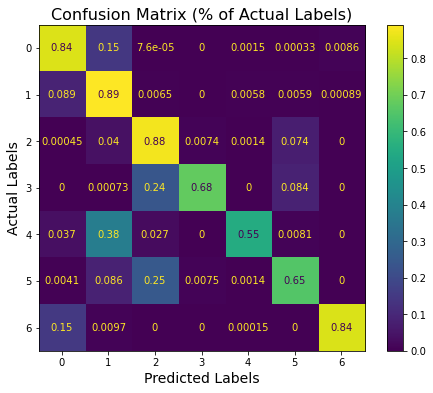

In [23]:
cv_score, oof_preds = train_cv(mlp_pipeline)

new_rows.append((
    'Multilayer Perceptron', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))

Original Train/Test Split


Accuracy: 0.64789
Training Time: 3.04s



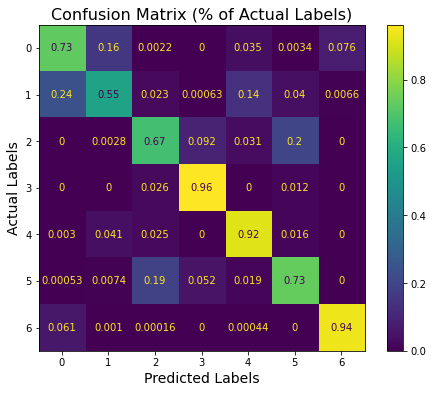

In [24]:
test_score, oof_preds = train_original(mlp_pipeline)

old_rows.append((
    'Multilayer Perceptron', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# XGBoost

In [25]:
# XGBoost Classifier
xgb_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'gbtree',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    ),
)

5-fold Cross-Validation


Fold 0 Accuracy:  0.87115 in 13.92s.
Fold 1 Accuracy:  0.87006 in 14.21s.
Fold 2 Accuracy:  0.87063 in 13.73s.
Fold 3 Accuracy:  0.86945 in 13.99s.
Fold 4 Accuracy:  0.87145 in 13.39s.

Average Accuracy: 0.87055
Worst Accuracy: 0.86945
Training Time: 69.24s



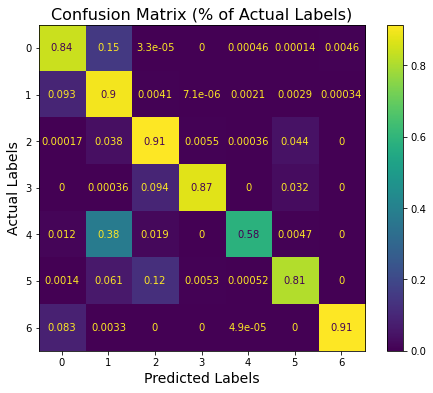

In [26]:
cv_score, oof_preds = train_cv(xgb_pipeline)

new_rows.append((
    'XGBoost', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))

Original Train/Test Split


Accuracy: 0.73655
Training Time: 2.08s



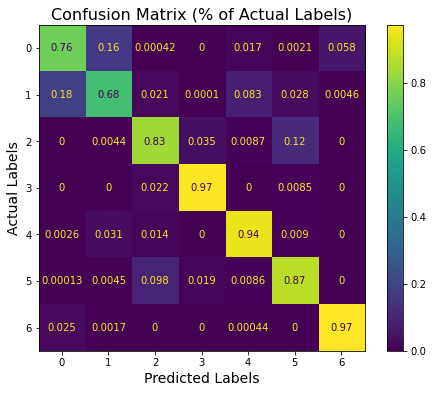

In [27]:
test_score, oof_preds = train_original(xgb_pipeline)

old_rows.append((
    'XGBoost', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# LightGBM 

In [28]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

5-fold Cross-Validation


Fold 0 Accuracy:  0.85006 in 5.14s.
Fold 1 Accuracy:  0.85744 in 4.9s.
Fold 2 Accuracy:  0.85594 in 4.79s.
Fold 3 Accuracy:  0.85245 in 4.94s.
Fold 4 Accuracy:  0.85308 in 4.94s.

Average Accuracy: 0.85379
Worst Accuracy: 0.85006
Training Time: 24.71s



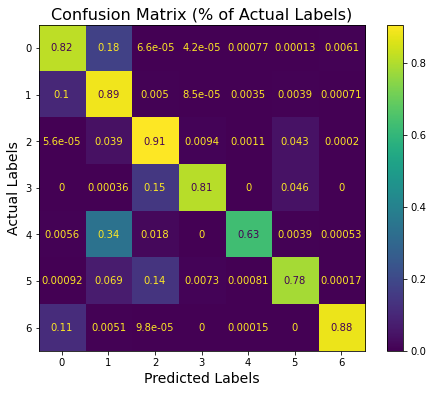

In [29]:
cv_score, oof_preds = train_cv(lgbm_pipeline)

new_rows.append((
    'LightGBM', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))

Original Train/Test Split


Accuracy: 0.73323
Training Time: 3.14s



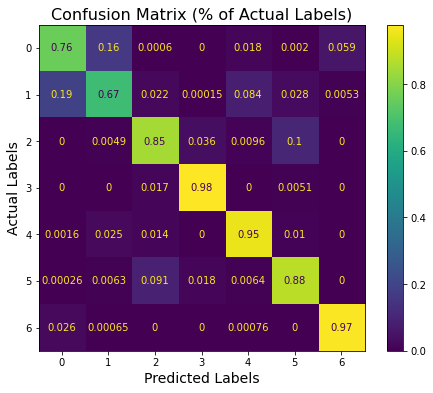

In [30]:
test_score, oof_preds = train_original(lgbm_pipeline)

old_rows.append((
    'LightGBM', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# CatBoost

In [31]:
# LightGBM Classifier
catboost_pipeline = make_pipeline(
    CatBoostClassifier(
        eval_metric = 'MultiClass',
        boosting_type = 'Plain',
        verbose = False,
        random_state = RANDOM_SEED,
    ),
)

5-fold Cross-Validation


Fold 0 Accuracy:  0.88428 in 153.34s.
Fold 1 Accuracy:  0.88424 in 152.35s.
Fold 2 Accuracy:  0.88668 in 151.32s.
Fold 3 Accuracy:  0.884 in 152.36s.
Fold 4 Accuracy:  0.887 in 152.68s.

Average Accuracy: 0.88524
Worst Accuracy: 0.884
Training Time: 762.04s



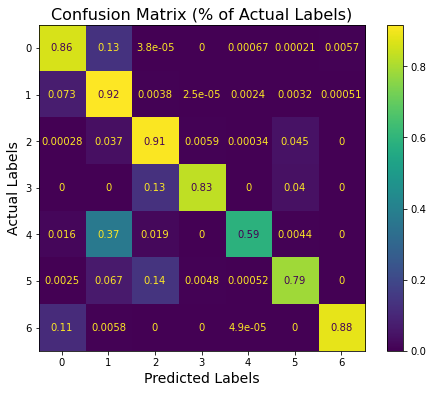

In [32]:
cv_score, oof_preds = train_cv(catboost_pipeline)

new_rows.append((
    'CatBoost', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))

Original Train/Test Split


Accuracy: 0.73885
Training Time: 9.85s



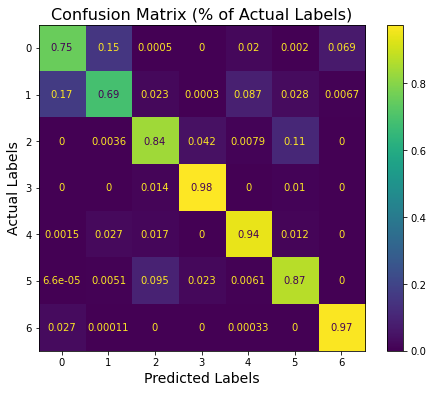

In [33]:
test_score, oof_preds = train_original(catboost_pipeline)

old_rows.append((
    'CatBoost', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Summary

In [34]:
pd.DataFrame.from_records(
    data = new_rows,
    columns = ['model','cv_scores','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('cv_scores')

,model,cv_scores,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
4,Naive_Bayes,0.642019,0.466687,0.807996,0.929379,0.120131,0.000211,0.031266,0.543540
2,LDA,0.679674,0.617966,0.761596,0.537590,0.588278,0.221110,0.502159,0.807947
1,Ridge_Regression,0.701097,0.680740,0.800167,0.886223,0.000000,0.000000,0.019059,0.216138
3,SGDClassifier,0.712899,0.700609,0.786993,0.864267,0.159447,0.042979,0.053665,0.494929
0,Logistic_Regression,0.724692,0.697885,0.800788,0.804469,0.430652,0.005899,0.267922,0.570258
7,LightGBM,0.853793,0.816324,0.885465,0.906276,0.808154,0.629306,0.784131,0.880839
5,Multilayer Perceptron,0.857907,0.843420,0.892087,0.876797,0.676374,0.549457,0.653308,0.842808
6,XGBoost,0.870548,0.841494,0.897381,0.912178,0.873680,0.582851,0.807336,0.913701
8,CatBoost,0.885240,0.860059,0.917265,0.911898,0.828904,0.590330,0.787816,0.883033


In [35]:
pd.DataFrame.from_records(
    data = old_rows,
    columns = ['model','accuracy','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('accuracy')

,model,accuracy,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
4,Naive_Bayes,0.502256,0.422692,0.550866,0.385295,0.795571,0.570571,0.547051,0.806975
3,SGDClassifier,0.518808,0.720808,0.335188,0.487870,0.855196,0.692486,0.698231,0.851662
1,Ridge_Regression,0.542707,0.624728,0.472759,0.436077,0.829642,0.635756,0.565661,0.806975
2,LDA,0.581262,0.649466,0.517541,0.538294,0.732538,0.640393,0.607089,0.806975
0,Logistic_Regression,0.593863,0.666730,0.518231,0.548504,0.879046,0.768035,0.650161,0.877657
5,Multilayer Perceptron,0.647889,0.727857,0.553918,0.674565,0.962521,0.915178,0.733873,0.936894
7,LightGBM,0.733227,0.756858,0.672634,0.845036,0.977853,0.949134,0.877622,0.973079
6,XGBoost,0.736546,0.760220,0.678699,0.833785,0.969336,0.942997,0.870652,0.973188
8,CatBoost,0.738852,0.754602,0.687036,0.838280,0.976150,0.942179,0.871244,0.972153
